# Neural networks with PyTorch

### Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module nn that provides a nice way to efficiently build large neural networks.



In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. 

### Our goal is to build a neural network that can take one of these images and predict the digit in the image.


In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

9920512it [00:06, 1599181.10it/s]                             


Extracting C:\Users\Arbidha/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 267050.13it/s]                         


Extracting C:\Users\Arbidha/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:01, 1370706.27it/s]                             


Extracting C:\Users\Arbidha/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 96076.22it/s]


Extracting C:\Users\Arbidha/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


*  training data loaded into trainloader
* we make that an iterator with iter(trainloader)
* This to loop through the dataset

for image, label in trainloader:
    ## do things with images and labels
    
* created the trainloader with a batch size of 64, and shuffle=True
* batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch.
* shuffle=True tells it to shuffle the dataset every time we start going through the data loader again.

### But here I'm just grabbing the first batch so we can check out the data. We can see below that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

In [3]:

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


# This is what one of the images looks like.

TypeError: Invalid dimensions for image data

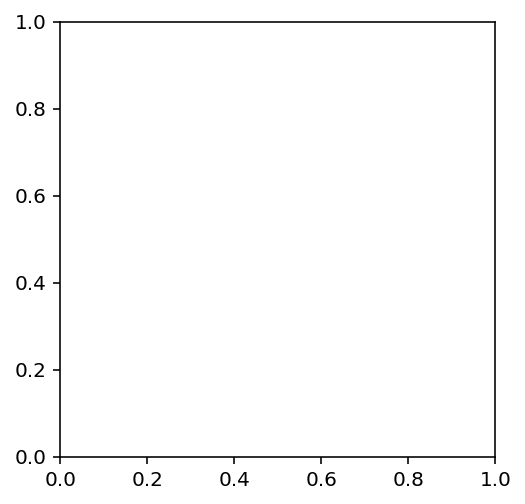

In [27]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

*   The networks you've seen so far are called fully-connected or dense networks. Each unit in one layer is connected to each unit in the next layer.In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples).

*   However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape (64, 1, 28, 28) to a have a shape of (64, 784), 784 is 28 times 28. This is typically called flattening, we flattened the 2D images into 1D vectors.

## OUR GOAL

Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

## Exercise 1: 
### Flatten the batch of images images. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [8]:
## Your solution
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the batch of images
inputs = images.view(images.shape[0], -1)
print(inputs)

# Create own random initial weight and bais
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)
 # output of your network, should have shape (64,10)
out = torch.mm(h, w2) + b2
print(out)

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
tensor([[ -3.6636, -10.2372,   6.6623, -11.6412,  -0.3391,  -7.2024,  -8.0738,
          12.5667,   4.9425,   5.4034],
        [  1.9316,  -7.3693,  12.2230,  -5.1341,   4.8626, -12.0173, -16.8580,
           6.5903,   2.6282,  -7.9222],
        [ -5.6430, -17.9577,   4.5458,   0.6003,   7.8570,  -7.6020,  -1.7694,
           3.7084,  15.5935,  -0.6830],
        [ -8.6005, -12.3773,   4.6897,  18.8306,   0.6668,  -9.1522,  -6.2259,
          18.3098,   7.9675,  11.4519],
        [  3.7715,  -7.3679,   5.5727,   2.8102,   8.4232,  -3.7337,  -8.9310,
           6.1208,  11.8703,   5.3602],
        [  8.6161,  -9.3104,   6.3886,   1.9412,  16.3784,  -9.1794, -18.5110,
           3.4504,  11.1045,  -4.342

Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. 

## Exercise 2: 
### Implement a function softmax that performs the softmax calculation and returns probability distributions for each example in the batch. 

### Note :
that you'll need to pay attention to the shapes when doing this. If you have a tensor a with shape (64, 10) and a tensor b with shape (64,), doing a/b will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need b to have a shape of (64, 1). This way PyTorch will divide the 10 values in each row of a by the one value in each row of b. Pay attention to how you take the sum as well. You'll need to define the dim keyword in torch.sum. Setting dim=0 takes the sum across the rows while dim=1 takes the sum across the columns.

#### To calculate this probability distribution, we often use the softmax function. Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$
#### What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

In [10]:
# Decalre softmax function

def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x),dim =1).view(-1,1)

probablity = softmax(out)

# Check if it has the shape (64,10)
print(probablity.shape)

# Sum to 1
print(probablity.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


# Building networks with PyTorch
PyTorch provides a module nn that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.


In [12]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
    

In [13]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

In [15]:
### Simpler and clean and most commonly used way


import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x
    
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

## Exercise 3: 
### Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the nn.ReLU module or  F.relu function.

##### It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use fc1, fc2, and fc3 as your layer names.

In [26]:
## Solution
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Defining layer 
        # I/p layer 784 , Hidden layer1 128 ,Hidden layer2 64 , softmax 10
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,64)
            
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)

        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x
    
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Using **nn.Sequential**

#### PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, nn.Sequential (documentation). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


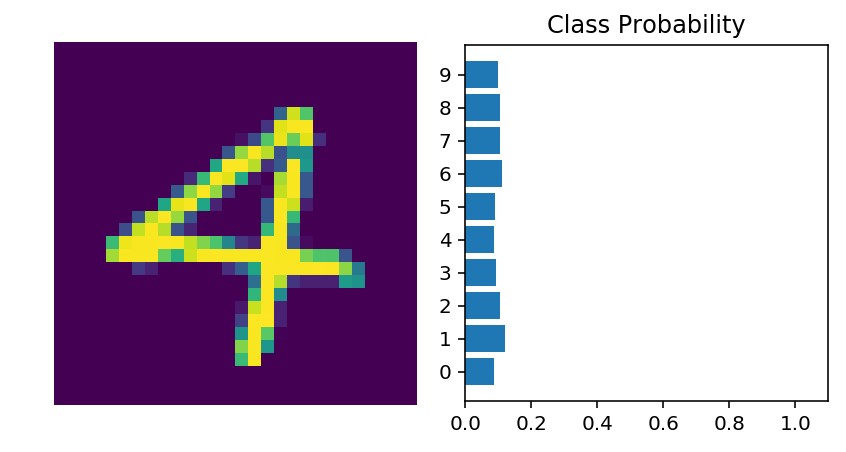

In [20]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

In [21]:

print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-0.0109,  0.0158, -0.0309,  ...,  0.0175,  0.0074, -0.0205],
        [-0.0252, -0.0353,  0.0079,  ..., -0.0205,  0.0070, -0.0052],
        [ 0.0057, -0.0334,  0.0204,  ..., -0.0234, -0.0020, -0.0010],
        ...,
        [ 0.0119,  0.0007,  0.0099,  ...,  0.0302,  0.0081,  0.0260],
        [-0.0123, -0.0343, -0.0029,  ...,  0.0044, -0.0043, -0.0140],
        [ 0.0119, -0.0111,  0.0202,  ..., -0.0220, -0.0099,  0.0109]],
       requires_grad=True)

In [22]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

In [23]:

print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In [ ]:
SS